In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT * from Fires", conn)

In [3]:
df.head(5)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [4]:
features_to_remove = []

In [5]:
def not_removed_features():
    return sorted(set(df.keys()) - set(features_to_remove))

# check null values

In [7]:
nulls = df.isnull().sum() / df.shape[0]

In [8]:
nulls.sort_values() 

OBJECTID                      0.000000
STATE                         0.000000
OWNER_DESCR                   0.000000
OWNER_CODE                    0.000000
LONGITUDE                     0.000000
LATITUDE                      0.000000
FIRE_SIZE_CLASS               0.000000
FIRE_SIZE                     0.000000
STAT_CAUSE_DESCR              0.000000
STAT_CAUSE_CODE               0.000000
DISCOVERY_DOY                 0.000000
DISCOVERY_DATE                0.000000
FIRE_YEAR                     0.000000
Shape                         0.000000
FOD_ID                        0.000000
FPA_ID                        0.000000
SOURCE_SYSTEM_TYPE            0.000000
SOURCE_SYSTEM                 0.000000
SOURCE_REPORTING_UNIT_NAME    0.000000
SOURCE_REPORTING_UNIT         0.000000
NWCG_REPORTING_AGENCY         0.000000
NWCG_REPORTING_UNIT_ID        0.000000
NWCG_REPORTING_UNIT_NAME      0.000000
FIPS_CODE                     0.360628
COUNTY                        0.360628
FIPS_NAME                

**No nulls in the targets: STAT_CAUSE_DESCR, STAT_CAUSE_DESCR**

In [9]:
thresh = 0.7
more_than_thresh_null = nulls[nulls.sort_values() > thresh].keys()
more_than_thresh_null

Index(['LOCAL_FIRE_REPORT_ID', 'FIRE_CODE', 'ICS_209_INCIDENT_NUMBER',
       'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME'],
      dtype='object')

In [10]:
# add them to 'features_to_remove'
features_to_remove.extend(list(more_than_thresh_null))

In [11]:
nulls = nulls.drop(more_than_thresh_null)
nulls.sort_values()

OBJECTID                      0.000000
STATE                         0.000000
OWNER_DESCR                   0.000000
OWNER_CODE                    0.000000
LONGITUDE                     0.000000
LATITUDE                      0.000000
FIRE_SIZE_CLASS               0.000000
FIRE_SIZE                     0.000000
STAT_CAUSE_DESCR              0.000000
STAT_CAUSE_CODE               0.000000
DISCOVERY_DOY                 0.000000
DISCOVERY_DATE                0.000000
Shape                         0.000000
NWCG_REPORTING_UNIT_ID        0.000000
SOURCE_REPORTING_UNIT_NAME    0.000000
SOURCE_REPORTING_UNIT         0.000000
FOD_ID                        0.000000
NWCG_REPORTING_UNIT_NAME      0.000000
FIRE_YEAR                     0.000000
NWCG_REPORTING_AGENCY         0.000000
SOURCE_SYSTEM                 0.000000
SOURCE_SYSTEM_TYPE            0.000000
FPA_ID                        0.000000
FIPS_NAME                     0.360628
FIPS_CODE                     0.360628
COUNTY                   

Not rellevant features for data exploration, identifires/ external DB identifires/ other:
1. OBJECTID = Global unique identifier.
2. Shape = used to plot the fire polygon on map.
3. FOD_ID = Global unique identifier.
4. SOURCE_SYSTEM_TYPE = Type of source database or system that the record was drawn from (federal, nonfederal, or interagency).
5. SOURCE_SYSTEM = Name of or other identifier for source database or system that the record was drawn from. See Table 1 in Short (2014), or \Supplements\FPAFODsourcelist.pdf, for a list of sources and their identifier.
6. FPA_ID = Unique identifier that contains information necessary to track back to the original record in the source dataset.
7. LOCAL_INCIDENT_ID =  Number or code that uniquely identifies an incident for a particular local fire management organization within a particular calendar year.

In [12]:
to_drop = ["OBJECTID", "Shape", "FOD_ID", "SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", "FPA_ID", "LOCAL_INCIDENT_ID"]
features_to_remove.extend(to_drop)

In [13]:
nulls = nulls.drop(to_drop)
nulls.sort_values()

NWCG_REPORTING_AGENCY         0.000000
FIRE_SIZE                     0.000000
LONGITUDE                     0.000000
OWNER_CODE                    0.000000
OWNER_DESCR                   0.000000
STAT_CAUSE_DESCR              0.000000
STAT_CAUSE_CODE               0.000000
STATE                         0.000000
DISCOVERY_DOY                 0.000000
DISCOVERY_DATE                0.000000
FIRE_YEAR                     0.000000
SOURCE_REPORTING_UNIT_NAME    0.000000
SOURCE_REPORTING_UNIT         0.000000
NWCG_REPORTING_UNIT_NAME      0.000000
NWCG_REPORTING_UNIT_ID        0.000000
FIRE_SIZE_CLASS               0.000000
LATITUDE                      0.000000
COUNTY                        0.360628
FIPS_NAME                     0.360628
FIPS_CODE                     0.360628
DISCOVERY_TIME                0.469372
CONT_DOY                      0.474101
CONT_DATE                     0.474101
FIRE_NAME                     0.509017
CONT_TIME                     0.516985
dtype: float64

In [14]:
not_removed_features()

['CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'COUNTY',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'FIPS_CODE',
 'FIPS_NAME',
 'FIRE_NAME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'FIRE_YEAR',
 'LATITUDE',
 'LONGITUDE',
 'NWCG_REPORTING_AGENCY',
 'NWCG_REPORTING_UNIT_ID',
 'NWCG_REPORTING_UNIT_NAME',
 'OWNER_CODE',
 'OWNER_DESCR',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'STATE',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR']

## NWCG features
1. NWCG_REPORTING_AGENCY = Active National Wildlife Coordinating Group (NWCG) Unit Identifier for the agency preparing the fire report (BIA = Bureau of Indian Affairs, BLM = Bureau of Land Management, BOR = Bureau of Reclamation, DOD = Department of Defense, DOE = Department of Energy, FS = Forest Service, FWS = Fish and Wildlife Service, IA = Interagency Organization, NPS = National Park Service, ST/C&L = State, County, or Local Organization, and TRIBE = Tribal Organization).
2. NWCG_REPORTING_UNIT_NAME =  Active NWCG Unit Name for the unit preparing the fire report.
3. NWCG_REPORTING_UNIT_ID = Active NWCG Unit Identifier for the unit preparing the fire report<br>
<br>
**NWCG_REPORTING_UNIT_NAME** and **NWCG_REPORTING_UNIT_ID** are *contained* in **NWCG_REPORTING_AGENCY** so we will use and anlayze only **NWCG_REPORTING_AGENCY**.

In [15]:
features_to_remove.extend(['NWCG_REPORTING_UNIT_NAME' , "NWCG_REPORTING_UNIT_ID"])

### check if NWCG_REPORTING_AGENCY is useful

In [16]:
len(df.NWCG_REPORTING_AGENCY.unique())

11

A lot of values, we will analyze the most common.

In [17]:
NWCG_REPORTING_AGENCY_val_counts = df.NWCG_REPORTING_AGENCY.value_counts()
NWCG_REPORTING_AGENCY_val_counts

ST/C&L    1377090
FS         220497
BIA        119943
BLM         97034
IA          21841
NPS         20893
FWS         19331
TRIBE        3739
DOD            81
BOR            14
DOE             2
Name: NWCG_REPORTING_AGENCY, dtype: int64

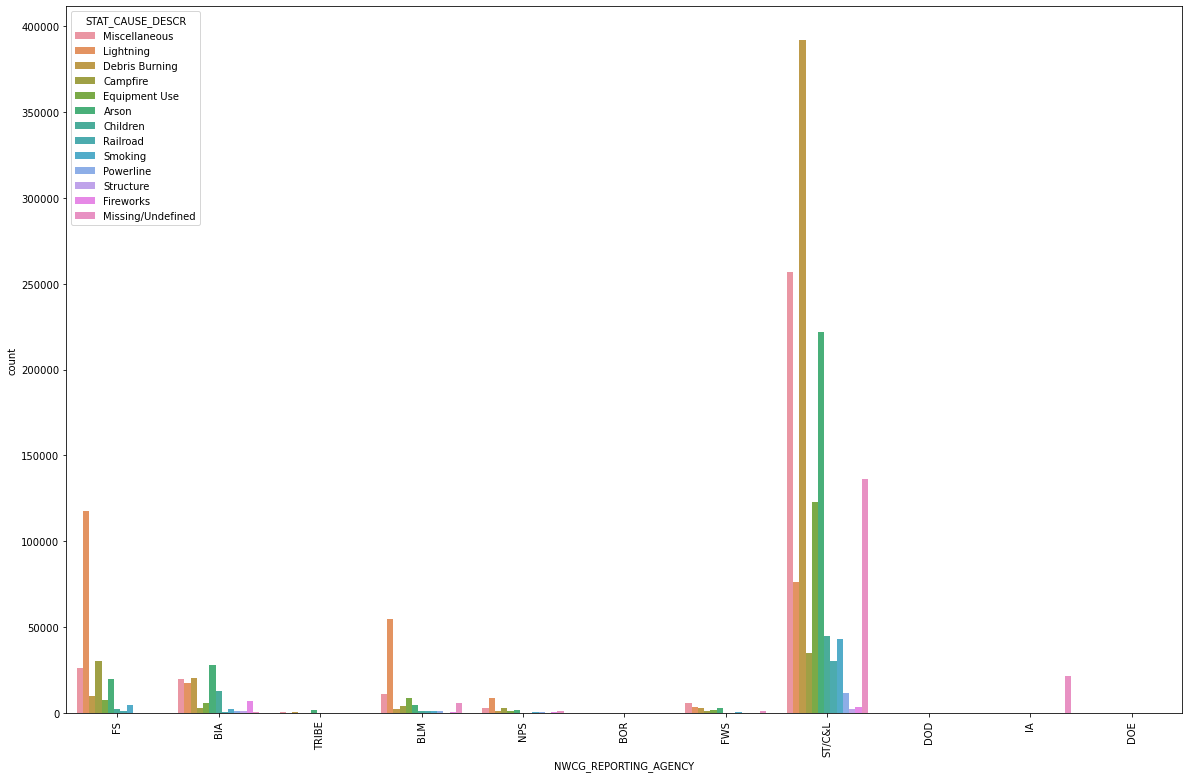

In [18]:
plt.figure(figsize=(20,13))
sns.countplot(x="NWCG_REPORTING_AGENCY", hue="STAT_CAUSE_DESCR", data=df)
plt.xticks(rotation=90)
plt.show()

can use 4 dummies ST/C&L, FS, BIA, BLM.

# End check if NWCG_REPORTING_AGENCY is useful

In [143]:
not_removed_features()

['CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'COUNTY',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'FIPS_CODE',
 'FIPS_NAME',
 'FIRE_NAME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'FIRE_YEAR',
 'LATITUDE',
 'LONGITUDE',
 'NWCG_REPORTING_AGENCY',
 'OWNER_CODE',
 'OWNER_DESCR',
 'SOURCE_REPORTING_UNIT',
 'SOURCE_REPORTING_UNIT_NAME',
 'STATE',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR']

# Explore: SOURCE_REPORTING_UNIT_NAME, SOURCE_REPORTING_UNIT
SOURCE_REPORTING_UNIT_NAME =  Code for the agency unit preparing the fire report, based on code/name in the source dataset.
SOURCE_REPORTING_UNIT = Name of reporting agency unit preparing the fire report, based on code/name in the source dataset.

In [92]:
len(df.SOURCE_REPORTING_UNIT.unique())

4992

4992 unique values. not use it.

In [144]:
features_to_remove.extend(["SOURCE_REPORTING_UNIT_NAME", "SOURCE_REPORTING_UNIT"])

In [145]:
not_removed_features()

['CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'COUNTY',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'FIPS_CODE',
 'FIPS_NAME',
 'FIRE_NAME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'FIRE_YEAR',
 'LATITUDE',
 'LONGITUDE',
 'NWCG_REPORTING_AGENCY',
 'OWNER_CODE',
 'OWNER_DESCR',
 'STATE',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR']

# FIPS_CODE, FIPS_NAME, COUNTY, STATE
1. COUNTY = County, or equivalent, in which the fire burned (or originated), based on nominal designation in the fire report.
2. FIPS_CODE = Three-digit code from the Federal Information Process Standards (FIPS) publication 6-4 for representation of counties and equivalent entities.
3. FIPS_NAME = County name from the FIPS publication 6-4 for representation of counties and equivalent entities.
4. STATE = Two-letter alphabetic code for the state in which the fire burned (or originated), based on the nominal designation in the fire report.
<br>
<br>
The first three are almost the same, and all contained in STATE, so we will use only STATE.

In [117]:
len(df.FIPS_NAME.unique())

1699

In [119]:
len(df.STATE.unique())

52

In [122]:
np.array(sorted(df.STATE.unique()))

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype='<U2')

In [124]:
nulls["STATE"] # also no null values

0.0

In [146]:
features_to_remove.extend(["COUNTY", "FIPS_CODE", "FIPS_NAME"])

In [147]:
not_removed_features()

['CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'FIRE_NAME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'FIRE_YEAR',
 'LATITUDE',
 'LONGITUDE',
 'NWCG_REPORTING_AGENCY',
 'OWNER_CODE',
 'OWNER_DESCR',
 'STATE',
 'STAT_CAUSE_CODE',
 'STAT_CAUSE_DESCR']

# FIRE NAME, FIRE_SIZE_CLASS
1. FIRE_NAME = Name of the incident, from the fire report (primary) or ICS-209 report (secondary).
2. FIRE_SIZE_CLASS =  Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).
<br>
<br>
FIRE_SIZE_CLASS - contained in FIRE_SIZE, we will use FIRE_SIZE since it is more accurate.

In [150]:
len(df.FIRE_NAME.unique()) # too many values, also seems not relevant, remove it.

493634

In [151]:
features_to_remove.extend(["FIRE_NAME", "FIRE_SIZE_CLASS"])

In [153]:
nulls[not_removed_features()]

CONT_DATE                0.474101
CONT_DOY                 0.474101
CONT_TIME                0.516985
DISCOVERY_DATE           0.000000
DISCOVERY_DOY            0.000000
DISCOVERY_TIME           0.469372
FIRE_SIZE                0.000000
FIRE_YEAR                0.000000
LATITUDE                 0.000000
LONGITUDE                0.000000
NWCG_REPORTING_AGENCY    0.000000
OWNER_CODE               0.000000
OWNER_DESCR              0.000000
STATE                    0.000000
STAT_CAUSE_CODE          0.000000
STAT_CAUSE_DESCR         0.000000
dtype: float64

# OWNER_CODE, OWNER_DESCR
1. OWNER_CODE = Code for primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident.
2. OWNER_DESCR = Name of primary owner or entity responsible for managing the land at the point of origin of the fire at the time of the incident.

In [113]:
len(df.OWNER_CODE.unique())

16

In [148]:
len(df.OWNER_DESCR.unique())

16

In [160]:
df.OWNER_DESCR.unique()

array(['USFS', 'STATE OR PRIVATE', 'MISSING/NOT SPECIFIED',
       'OTHER FEDERAL', 'BIA', 'FWS', 'TRIBAL', 'PRIVATE', 'STATE', 'BLM',
       'NPS', 'BOR', 'FOREIGN', 'MUNICIPAL/LOCAL', 'COUNTY',
       'UNDEFINED FEDERAL'], dtype=object)

In [159]:
### check if OWNER_CODE is useful

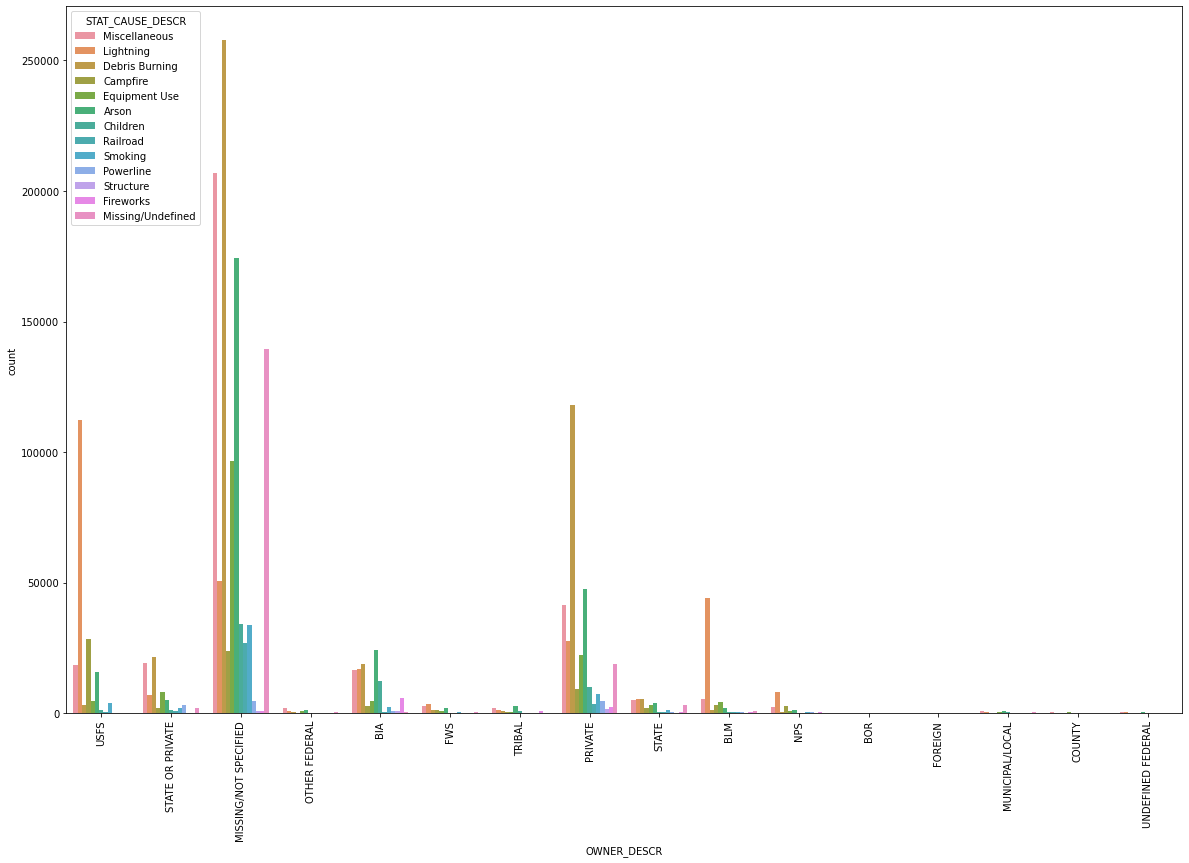

In [161]:
plt.figure(figsize=(20,13))
sns.countplot(x="OWNER_DESCR", hue="STAT_CAUSE_DESCR", data=df)
plt.xticks(rotation=90)
plt.show()

In [169]:
df.OWNER_DESCR.value_counts() / df.shape[0]

MISSING/NOT SPECIFIED    0.558817
PRIVATE                  0.167417
USFS                     0.100155
BIA                      0.056805
STATE OR PRIVATE         0.038225
BLM                      0.033650
STATE                    0.016374
NPS                      0.009319
FWS                      0.006483
TRIBAL                   0.004761
OTHER FEDERAL            0.003431
MUNICIPAL/LOCAL          0.002253
UNDEFINED FEDERAL        0.001173
COUNTY                   0.000979
BOR                      0.000152
FOREIGN                  0.000008
Name: OWNER_DESCR, dtype: float64

We can see that there is owners that had some fires more than other fires,
For example, "USFS" has more fires of type lighting, but "PRIVATE" has more fires of type Debris.

maybe we can use it as 3 features: "MISSING/NOT SPECIFIED"/ "PRIVATE"/ "USFS"

In [170]:
# we will use only the OWNER_DESCR
features_to_remove.extend(["OWNER_CODE"])

In [172]:
nulls[not_removed_features()]

CONT_DATE                0.474101
CONT_DOY                 0.474101
CONT_TIME                0.516985
DISCOVERY_DATE           0.000000
DISCOVERY_DOY            0.000000
DISCOVERY_TIME           0.469372
FIRE_SIZE                0.000000
FIRE_YEAR                0.000000
LATITUDE                 0.000000
LONGITUDE                0.000000
NWCG_REPORTING_AGENCY    0.000000
OWNER_DESCR              0.000000
STATE                    0.000000
STAT_CAUSE_CODE          0.000000
STAT_CAUSE_DESCR         0.000000
dtype: float64

In [173]:
# features to use
df_to_analyze = df[not_removed_features()]

In [174]:
df_to_analyze

,CONT_DATE,CONT_DOY,CONT_TIME,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,FIRE_YEAR,LATITUDE,LONGITUDE,NWCG_REPORTING_AGENCY,OWNER_DESCR,STATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
0,2453403.5,33.0,1730,2453403.5,33,1300,0.10,2005,40.036944,-121.005833,FS,USFS,CA,9.0,Miscellaneous
1,2453137.5,133.0,1530,2453137.5,133,0845,0.25,2004,38.933056,-120.404444,FS,USFS,CA,1.0,Lightning
2,2453156.5,152.0,2024,2453156.5,152,1921,0.10,2004,38.984167,-120.735556,FS,STATE OR PRIVATE,CA,5.0,Debris Burning
3,2453189.5,185.0,1400,2453184.5,180,1600,0.10,2004,38.559167,-119.913333,FS,USFS,CA,1.0,Lightning
4,2453189.5,185.0,1200,2453184.5,180,1600,0.10,2004,38.559167,-119.933056,FS,USFS,CA,1.0,Lightning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2457291.5,269.0,1843,2457291.5,269,1726,0.01,2015,40.481637,-122.389375,ST/C&L,STATE OR PRIVATE,CA,13.0,Missing/Undefined
1880461,NaN,NaN,None,2457300.5,278,0126,0.20,2015,37.617619,-120.938570,ST/C&L,MUNICIPAL/LOCAL,CA,9.0,Miscellaneous
1880462,NaN,NaN,None,2457144.5,122,2052,0.10,2015,37.617619,-120.938570,ST/C&L,MUNICIPAL/LOCAL,CA,13.0,Missing/Undefined
1880463,NaN,NaN,None,2457309.5,287,2309,2.00,2015,37.672235,-120.898356,ST/C&L,MUNICIPAL/LOCAL,CA,13.0,Missing/Undefined


In [175]:
df_to_analyze.to_csv("df_to_analyze.csv")